In [1]:
import sawg.segmentation
import sawg.hpc
import matplotlib.pyplot as plt
import numpy as np
import os

## Load and prepare data

In [2]:
expt_path = '/allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/MERSCOPE/macaque/1191380492/'

# MERSCOPE detected transcripts CSV file
csv_file = expt_path + 'detected_transcripts.csv'

# path to MERSCOPE image mosaics
image_path = expt_path + 'images/'

# npz cache file (for faster loading, since CSV is very slow) 
cache_file = csv_file + '.npz'

save_path = '/allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/jacobquon/fail_20230718/'

# path to save segmented tiles
tile_save_path = os.path.join(save_path, 'segmentation')

# file to store fully segmented and merged per-spot cell IDS
segmentation_file = os.path.join(save_path, 'segmentation.npy')

# AnnData file containing cell-by-gene matrix and x,y positions
anndata_file = os.path.join(save_path, 'cell_by_gene.h5ad')

In [3]:
# load full table
table = sawg.SpotTable.load_merscope(
    csv_file=csv_file, 
    cache_file=cache_file, 
    image_path=image_path, 
    max_rows=None
)

# For testing, pick a small sub-region to segment
# subrgn = [[2000, 5000], [2000, 4000]]

# For full run, pick everything backed by DAPI image
subrgn = table.get_image(channel='DAPI').bounds()

subtable = table.get_subregion(xlim=subrgn[0], ylim=subrgn[1])

Loading from npz..


## Run segmentation on HPC

In [4]:
# split into tiles
tiles = subtable.grid_tiles(max_tile_size=200, overlap=30)
regions = [tile.parent_region for tile in tiles]

  0%|          | 0/61 [00:00<?, ?it/s]

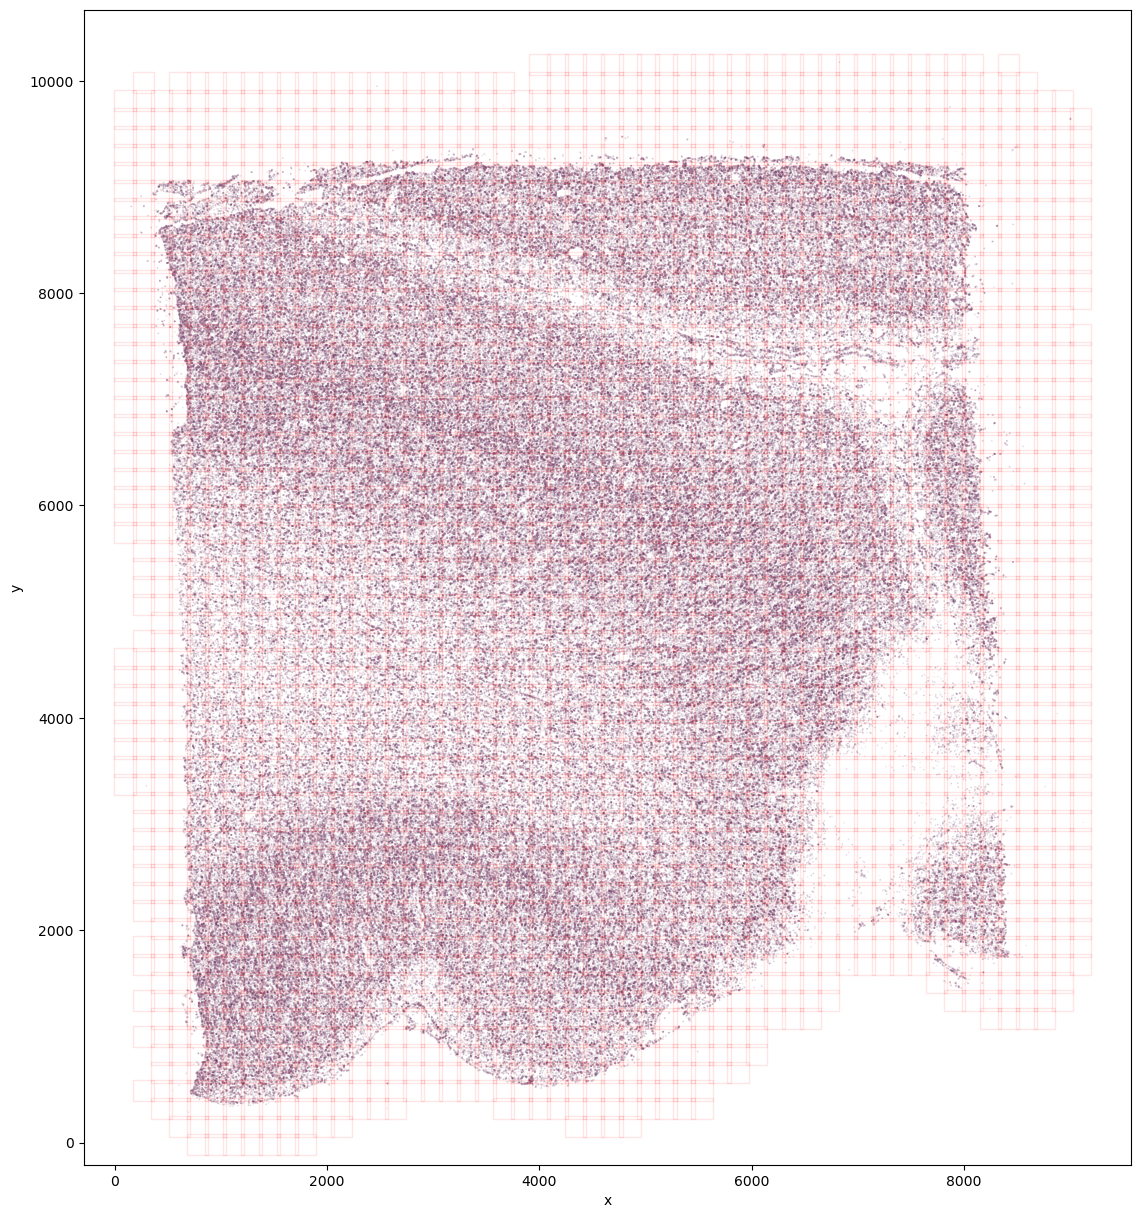

In [5]:
fig, ax = plt.subplots(figsize=(15, 15))
subtable[::200].scatter_plot(ax=ax)
for tile in tiles:
    tile.plot_rect(ax=ax, color=(1, 0, 0, 0.1))

In [6]:
# define a segmentation method
seg_method = sawg.segmentation.CellposeSegmentationMethod
seg_opts = dict(options={
    'region': None,
    'cellpose_model': 'cyto2',
    'cellpose_gpu': 'auto',
    'px_size': 0.108,          # um / px
    'cell_dia': 10,            # um
    'z_plane_thickness': 1.5,  # um
    'images': {'cyto': 'total_mrna', 'nuclei': 'DAPI'}, 
    'cellpose_options': {
        'batch_size': 8,
    },
})

# generate specifications for segmenting each tile on HPC
if not os.path.exists(tile_save_path):
    os.mkdir(tile_save_path)
run_spec = {}
for i,tile in enumerate(tiles):
    run_spec[i] = (
        sawg.segmentation.run_segmentation,
        (),
        dict(
            load_func=sawg.SpotTable.load_merscope,
            load_args=dict(
                csv_file=csv_file,
                cache_file=cache_file,
                image_path=image_path,
            ),
            subregion=tile.parent_region,  # each array job will pick from a different region
            method_class=seg_method,
            method_args=seg_opts,
            result_file=os.path.join(tile_save_path, f'segmentation_result_{i}.pkl'),
            cell_id_file=os.path.join(tile_save_path, f'segmentation_result_{i}.npy'),
        )
    )
    
print(f"Generated segmentation spec for {len(run_spec)} tiles")

Generated segmentation spec for 3014 tiles


In [7]:
# run segmentation on all tiles
jobs = sawg.hpc.run_slurm_func(
    run_spec=run_spec,
    conda_env='/home/jacob.quon/miniconda3/envs/sawg',
    hpc_host='hpc-login',
    job_path='/allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/jacobquon/fail_20230718/hpc-jobs',
    partition='celltypes', 
    job_name='test-job',
    nodes=1,
    ntasks=1,
    array=f'0-{len(run_spec)-1}',
    mincpus=1,
    gpus_per_node=1,
    mem='20G',
    time='0:30:00',
    mail_user=None,    
)

In [8]:
import pickle

with open('/allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/jacobquon/fail_20230718/hpc-jobs/jobs.pkl', 'wb') as f:
    pickle.dump(jobs, f)

In [9]:
# wait for jobs to finish
import time, os
from tqdm.notebook import tqdm
with tqdm(total=len(jobs)) as pbar:
    while True:
        finished = [j for j in jobs if os.path.exists(j.output_file)]
        n_finished = len(finished)
        pbar.update(n_finished - pbar.n)
        print(f'{n_finished} / {len(jobs)}  {jobs.state_counts()}')
        time.sleep(60)
        if n_finished == len(jobs):
            break


  0%|          | 0/3014 [00:00<?, ?it/s]

0 / 3014  {'NO': 3014}


Killed by signal 2.


KeyboardInterrupt: 

In [16]:
# merge results back together

import pickle
import numpy as np
from tqdm.notebook import tqdm

subtable.cell_ids = np.empty(len(subtable), dtype=int)
subtable.cell_ids[:] = -1

merge_results = []

skipped = []
for i,tile_spec in enumerate(tqdm(run_spec.values())):
#     seg_result = pickle.load(open(tile_spec[2]['output_file'], 'rb'))
    cell_id_file = tile_spec[2]['cell_id_file']
    if not os.path.exists(cell_id_file):
        print(f"Skipping tile {i} : no cell ID file generated")
        skipped.append(i)
        continue
    tile = tiles[i]
    tile.cell_ids = np.load(cell_id_file)
    result = subtable.merge_cells(tile, padding=5)
    merge_results.append(result)
    

  0%|          | 0/3014 [00:00<?, ?it/s]

In [ ]:
for i in skipped:
    print(jobs[i].error)
    print(jobs[i].output)
    

In [20]:
# save segmented cell IDs
np.save(segmentation_file, subtable.cell_ids)
print("Saved to", segmentation_file)

Saved to /allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/MERSCOPE/macaque/1191380492/segmentation.npy


## Process results

In [4]:
# We can reload this if the notebook is restarted:
subtable.cell_ids = np.load(segmentation_file)

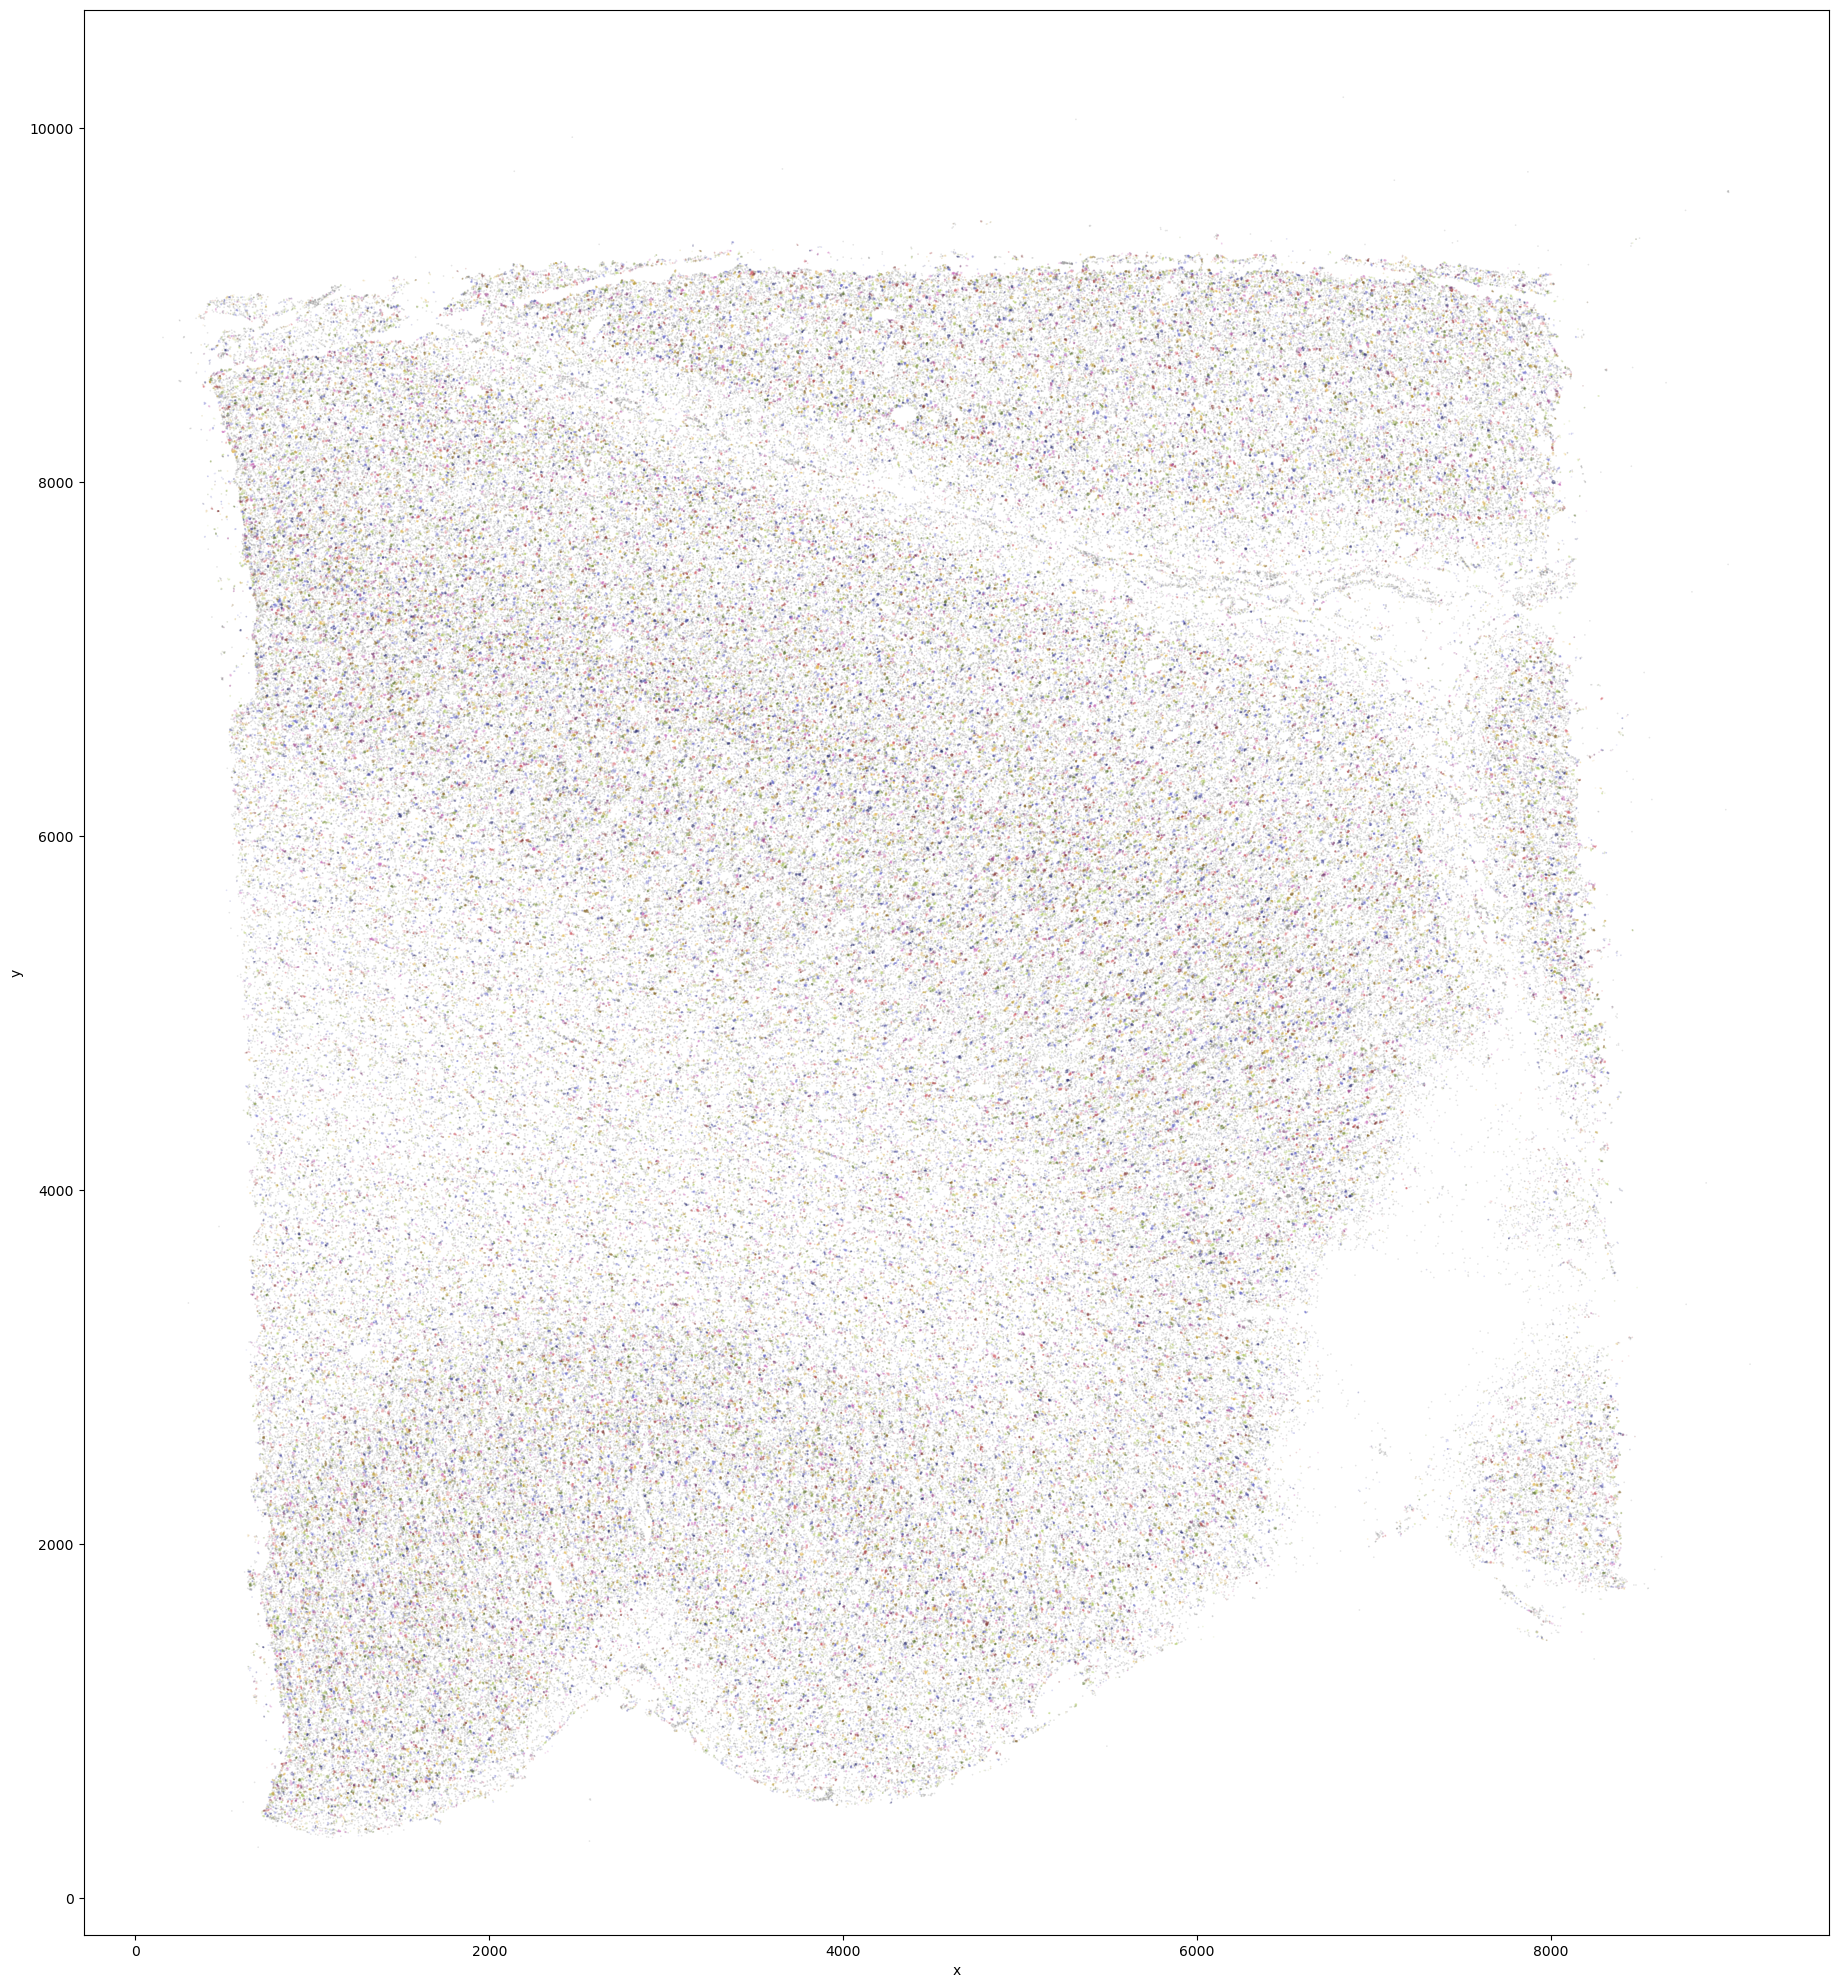

In [5]:
fig,ax = plt.subplots(figsize=(15, 15))
subtable[::200].scatter_plot(ax=ax, color='cell')

### filter cells by spot count

In [6]:
filtered_table = subtable.filter_cells(real_cells=True, min_spot_count=500)

### plot cell area vs density

Text(0, 0.5, 'cell spot density (log 1/um^2)')

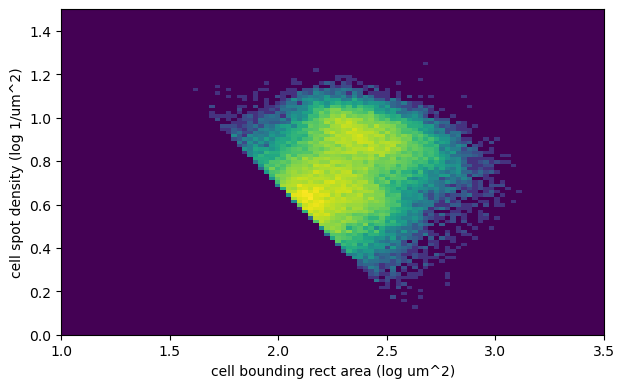

In [7]:
# get bounding rect for all remaining cells
cells, counts = np.unique(filtered_table.cell_ids, return_counts=True)
cell_bounds = np.array([filtered_table.cell_bounds(cid) for cid in cells])
area = (cell_bounds[:,1] - cell_bounds[:,0]) * (cell_bounds[:,3] - cell_bounds[:,2])
density = counts/area
fig, ax = plt.subplots(figsize=(7, 7))

# scatter plot is too dense to see structure; use histogram instead
# ax.scatter(area, counts/area, s=3, color=(0, 0, 0, 0.01))
# ax.set_yscale('log')
# ax.set_xscale('log')

area_bins = np.linspace(1, 3.5, 100)
density_bins = np.linspace(0, 1.5, 100)
hist, _, _ = np.histogram2d(density, area, bins=(10**density_bins, 10**area_bins))
ax.imshow(
    hist+1,
    norm='log',
    extent=(area_bins[0], area_bins[-1], density_bins[0], density_bins[-1]), 
    origin='lower'
)
ax.set_xlabel('cell bounding rect area (log um^2)')
ax.set_ylabel('cell spot density (log 1/um^2)')

### generate a cell-by-gene table

In [8]:
cell_by_gene_df = filtered_table.cell_by_gene_dataframe()
cell_by_gene_df

ABCC5  ABLIM2     ABR  ADAMTS3  ADAMTSL3  ADARB2  ADCY8  ADGRL2  \
cell                                                                        
-1        40452  292235  839081    12509     16336   52537  36861   48275   
 0            1       6      21      138         5       2      4       6   
 352          0       0       9        0         0       0      4       0   
 396          2       1      14        0         0       0      5       0   
 487          0       5       6        0         0       0      0       5   
...         ...     ...     ...      ...       ...     ...    ...     ...   
 2249962      0       0       3        0         0       0      0       0   
 2250006      7       7      23        1         0       2      3       3   
 2250320      5       9      35        1         0       0      2       4   
 2250498      4       3      22        1         0       0      2       5   
 2250844      1       0       7        0         0       0      3       2   

          ADGRL3  ADGRL4  ...    WLS    WNK2   WWOX  ZBTB20    ZEB2  ZFPM2  \
cell                      ...                                                
-1        120876   10826  ...  86606  446657  18590  238696  496974  32561   
 0             8       3  ...      9      11      0      11      10      2   
 352           4       0  ...      7      15      1      13       2      0   
 396           4       0  ...      5      27      1      11       2      1   
 487           0       1  ...      3       2      0       9       2      0   
...          ...     ...  ...    ...     ...    ...     ...     ...    ...   
 2249962       4       0  ...      5       1      0       5       1      3   
 2250006      13       1  ...      5      23      0       1       8      1   
 2250320      11       0  ...      3      14      0       3       7      1   
 2250498      11       0  ...     21       8      1       2       2      0   
 2250844       2       0  ...      0       8      1       0       0      0   

          ZMAT4  ZNF385D  ZNF804B  ZSWIM6  
cell                                       
-1        30449    20466     3985   58462  
 0            2        2        0       5  
 352          0        0        0       3  
 396          0        0        0       1  
 487          0        0        0       1  
...         ...      ...      ...     ...  
 2249962      0        0        0       1  
 2250006      4        0        0       4  
 2250320      0        1        1       0  
 2250498      0        0        0       0  
 2250844      0        0        0       1  

[46797 rows x 550 columns]

### generate centroid locations

In [9]:
centroids = 0.5 * (cell_bounds[:, 1::2] + cell_bounds[:, ::2])

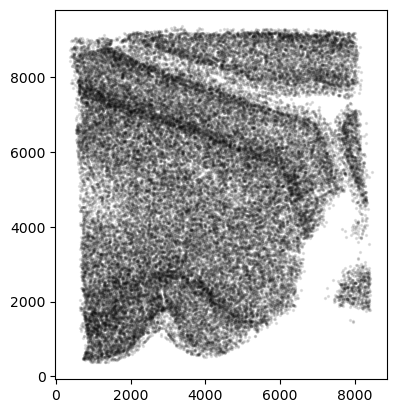

In [10]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(centroids[:, 0], centroids[:, 1], s=2, color=(0, 0, 0, 0.1));

### write anndata file

In [11]:
import anndata
adata = anndata.AnnData(cell_by_gene_df)
adata.obs_names = cell_by_gene_df.index
adata.var_names = cell_by_gene_df.columns
adata.obs['x'] = centroids[:, 0]
adata.obs['y'] = centroids[:, 1]
adata.write(anndata_file)

/tmp/ipykernel_931191/1240251742.py:2: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(cell_by_gene_df)
/home/luke/miniconda3/envs/transcriptomics/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/luke/miniconda3/envs/transcriptomics/lib/python3.10/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [-1, 0, 352, 396, 487]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
